In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import itertools
import numpy as np
import random
import statsmodels.api as sm
# prophet by Facebook
from fbprophet import Prophet
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

C:\anaconda\envs\ml1\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


READING THE DATA 

In [2]:
df = pd.read_excel("C:/Users/User/Downloads/Sales & Qty Sold Daily Data.xlsx")
df

,BRANCH_CODE,Date - Year,Date - Month,Date - Day,Total Ret Sales,Qty Sold Retoff
0,ALM,2018,April,27,5690.47,4.0
1,ALM,2018,April,29,1333.33,2.0
2,ALM,2018,April,30,666.66,2.0
3,ALM,2018,May,1,809.52,1.0
4,ALM,2018,May,6,14952.39,6.0
...,...,...,...,...,...,...
10348,SOFITL,2018,December,24,3075.24,1.0
10349,SOFITL,2018,December,25,4207.62,2.0
10350,SOFITL,2018,December,27,95.24,1.0
10351,SOFITL,2018,December,29,5046.67,2.0


COMBINING THE DAY MONTH YEAR COLUMN

In [3]:
df1=df[["Date - Year","Date - Month","Date - Day","BRANCH_CODE","Total Ret Sales","Qty Sold Retoff"]]

CONVERTING SALES QTY INTO FLOAT AND DATE INTO DATETIME FOREMATE 

In [4]:
df1["Total Ret Sales"]=df1["Qty Sold Retoff"].astype(float)
df1["Sales"]=df1["Total Ret Sales"]
df1['Date']=pd.to_datetime(df1['Date - Month']+df1['Date - Year'].astype(str)+df1['Date - Day'].astype(str),format='%B%Y%d')
df1=df1[["Date","BRANCH_CODE","Sales"]]

WE ARE ONLY CONCIDERING BRANCH MOE HERE SO SLECETING ONLY THE BRANCH MOE

In [5]:
df1=df1[df1["BRANCH_CODE"]=="MOE"]

TAKING THE DATE AND SALES COLUMNS 

In [6]:
df1=df1[["Date","Sales"]]

CREATING A DATA FRAME WITH THE SAME DATE RANGE 

In [7]:
df1['Date'] =  pd.to_datetime(df1['Date'],format = '%Y/%m/%d')
df_A=pd.date_range(start='2014-01-01', end='2018-12-31')
df_date=pd.DataFrame(df_A)
df_date.columns=["Date"]

MERGING THE DATA FRAME WITH THE DATE TO GET ALL THE DATE 

In [8]:
df3=df_date.merge(df1, how='left', on='Date').ffill(0)

PLOTING THE DATA

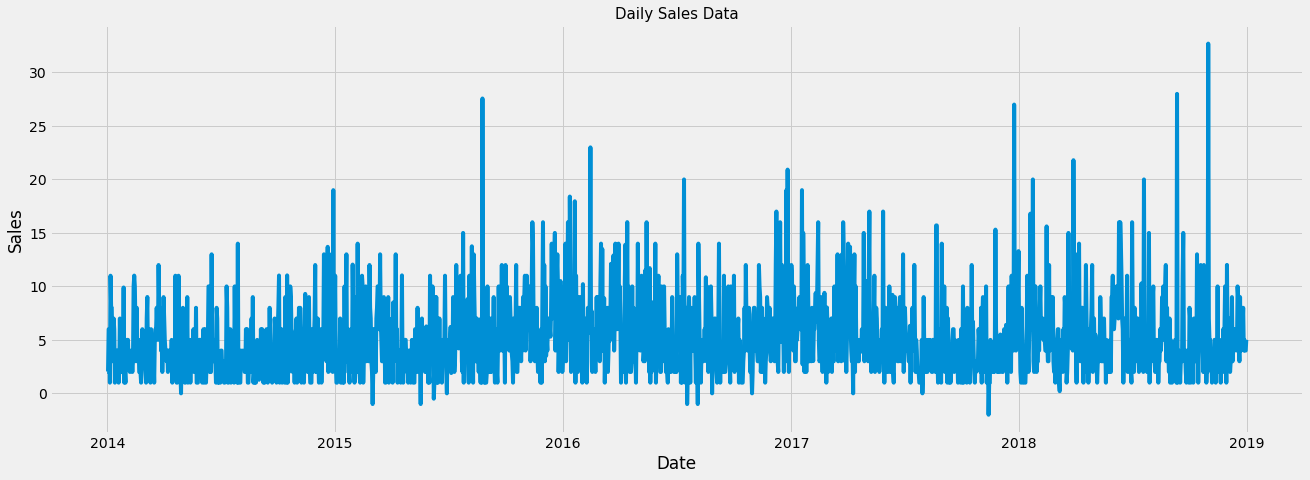

In [9]:
df=df3
fig, ax = plt.subplots(figsize=(20,7))
a = sns.lineplot(x="Date", y="Sales", data=df)
a.set_title("Daily Sales Data",fontsize=15)
plt.show()

EXPLORING THE DATA 

In [10]:
def date_features(df, label=None):
    df = df.copy()

    df['date'] = df.Date
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['dayofweek'] = df['date'].dt.strftime('%A')
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X
X, y = date_features(df, label='Sales')
df_new = pd.concat([X, y], axis=1)
df_new.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Sales
0,Wednesday,1,January,2014,1,1,1,2.0
1,Thursday,1,January,2014,2,2,1,2.0
2,Friday,1,January,2014,3,3,1,6.0
3,Saturday,1,January,2014,4,4,1,6.0
4,Sunday,1,January,2014,5,5,1,1.0


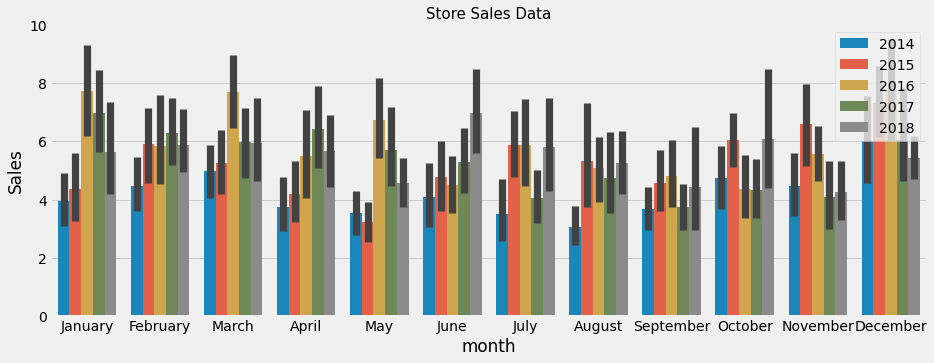

In [11]:
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="Sales",hue = 'year',data=df_new)
a.set_title("Store Sales Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

Text(0.5, 1.0, 'Total Sales received By year')

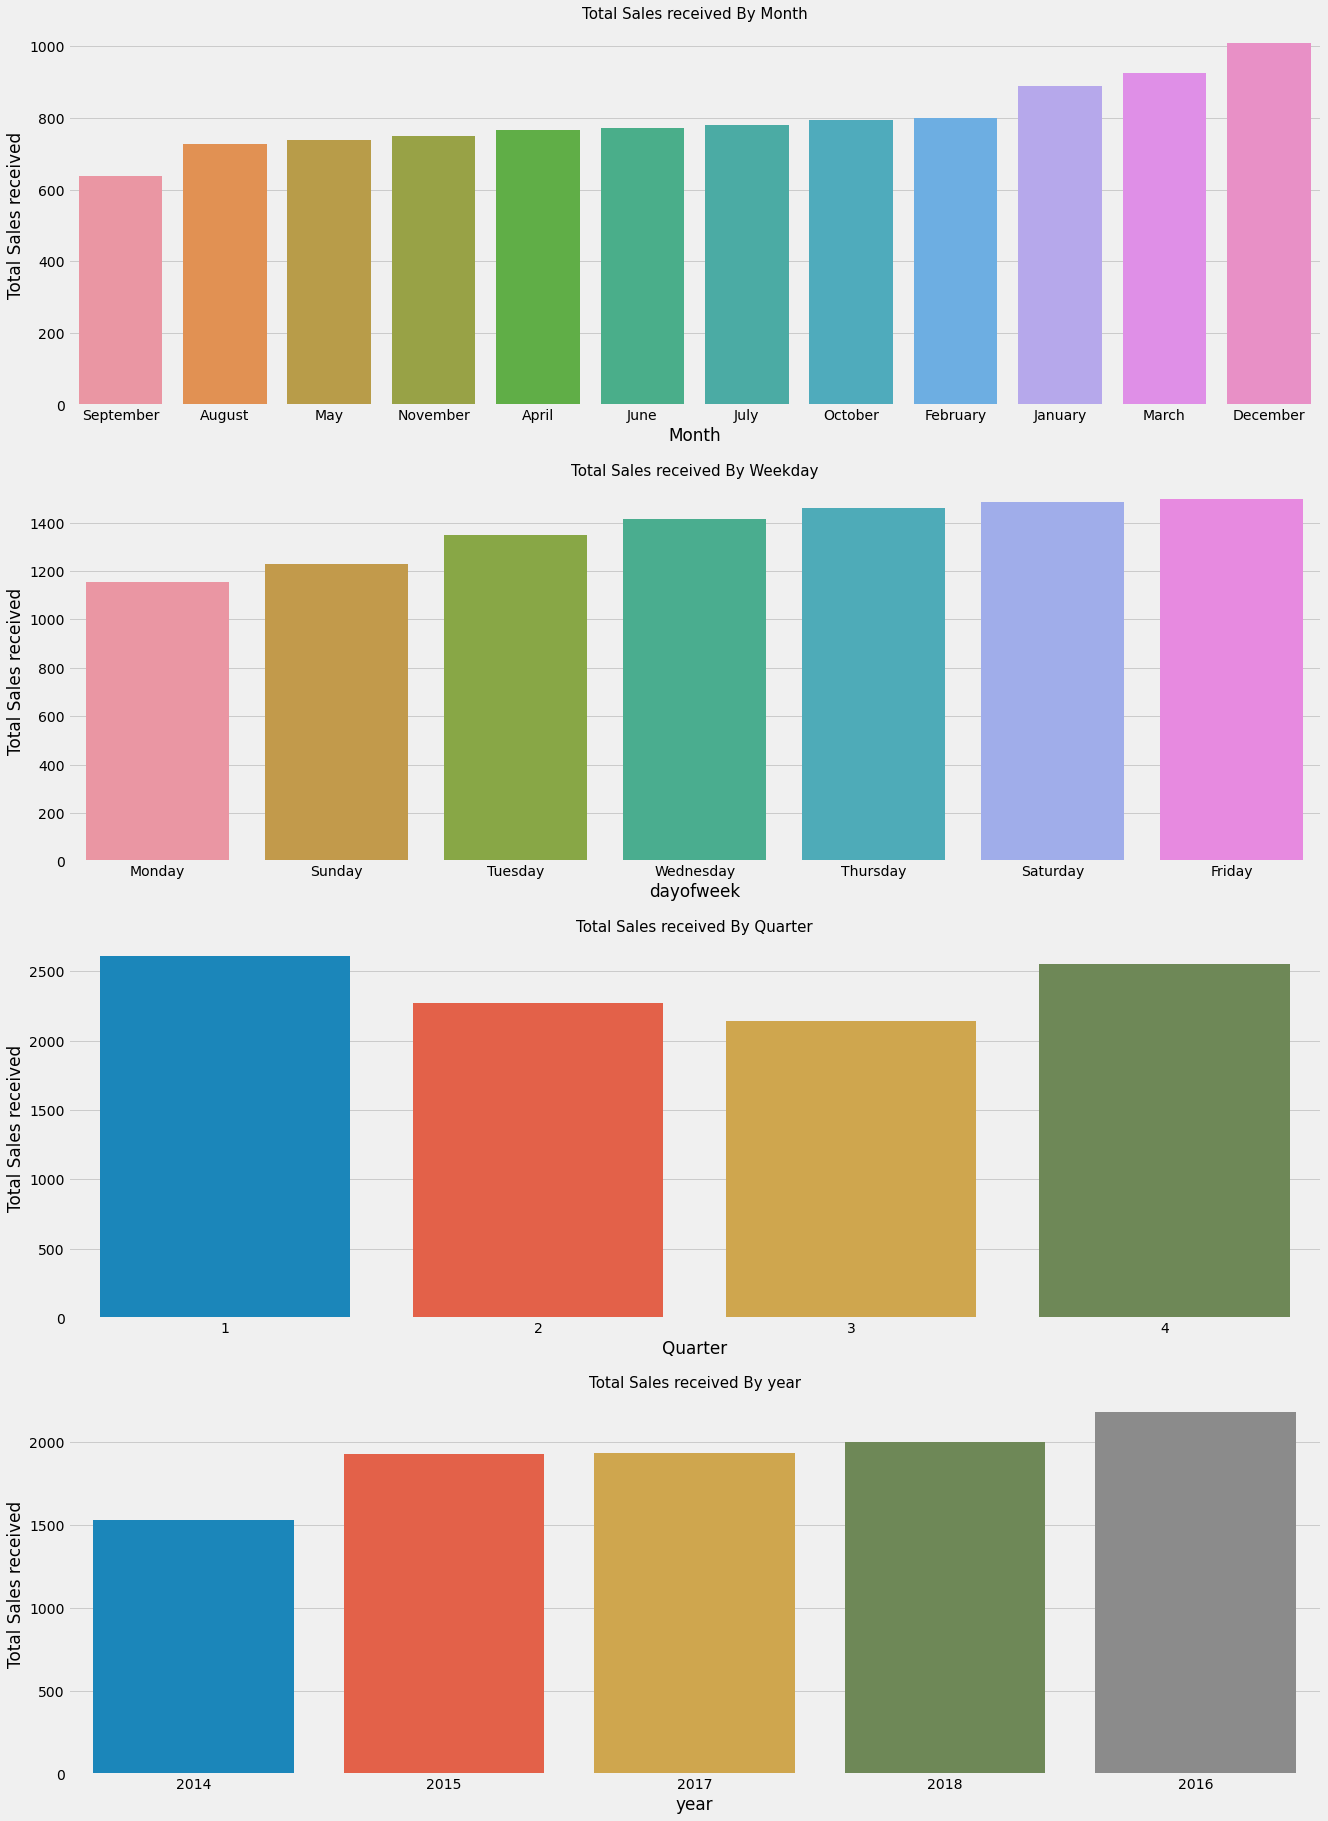

In [12]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(20,30)

monthAggregated = pd.DataFrame(df_new.groupby("month")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="month",y="Sales",ax=ax1)
ax1.set(xlabel='Month', ylabel='Total Sales received')
ax1.set_title("Total Sales received By Month",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("dayofweek")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="dayofweek",y="Sales",ax=ax2)
ax2.set(xlabel='dayofweek', ylabel='Total Sales received')
ax2.set_title("Total Sales received By Weekday",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("quarter")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="quarter",y="Sales",ax=ax3)
ax3.set(xlabel='Quarter', ylabel='Total Sales received')
ax3.set_title("Total Sales received By Quarter",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("year")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="year",y="Sales",ax=ax4)
ax4.set(xlabel='year', ylabel='Total Sales received')
ax4.set_title("Total Sales received By year",fontsize=15)

RENAMING THE COLUMN NAME WITH ds AND  y (required to do the next steps in fb prophet)

In [13]:
df=df.rename(columns={'Date':'ds','Sales':'y'})


SPLITTING THE DATA (WE NEED TO TAKE OUT THE 2018 YEAR DATA FROM THE MODEL SO THAT WE CAN CHECKS THE EFFICIENCY OF THE MODEL )

In [14]:
end_date = '2017-12-31'
mask1 = (df['ds'] <= end_date)
mask2 = (df['ds'] > end_date)

In [15]:
X_tr = df.loc[mask1]
X_tst = df.loc[mask2]
print("train shape",X_tr.shape)
print("test shape",X_tst.shape)

train shape (1461, 2)
test shape (365, 2)


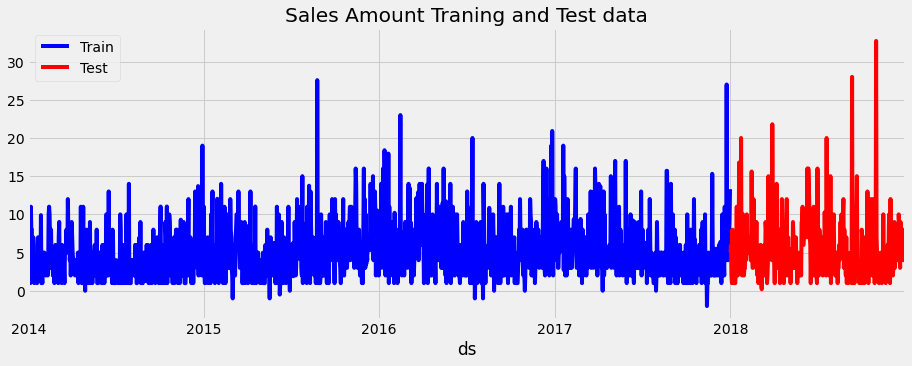

In [16]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
X_tr.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
X_tst.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Sales Amount Traning and Test data')
plt.show()

FITTING THE MODEL

In [17]:
model =Prophet()
model.fit(X_tr)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FORECATING THE MODEL

In [18]:
future = model.make_future_dataframe(periods=57, freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
1511,2018-02-20,5.416233,1.013564,9.506258
1512,2018-02-21,5.692015,1.472323,10.047396
1513,2018-02-22,5.731037,1.197578,9.904846
1514,2018-02-23,5.772687,1.215737,9.797312
1515,2018-02-24,5.580548,0.979428,9.533560
1516,2018-02-25,4.700730,0.043633,9.017854
1517,2018-02-26,4.277725,-0.370714,8.476619


PLOTING 

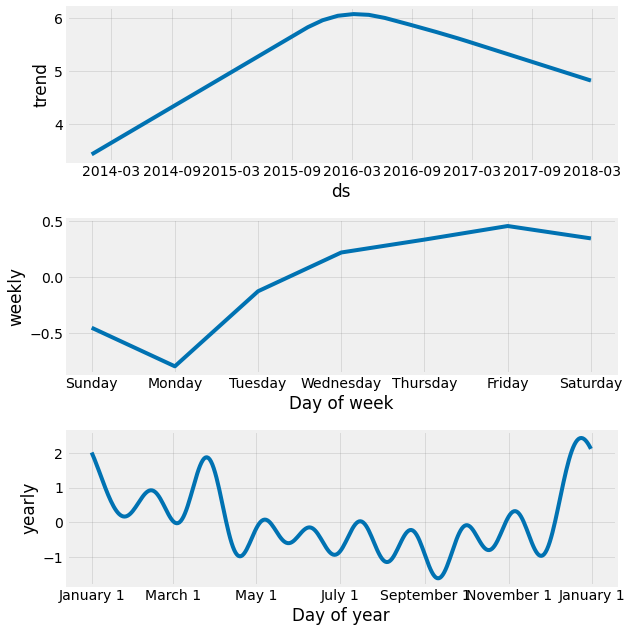

In [19]:
fig = model.plot_components(forecast)

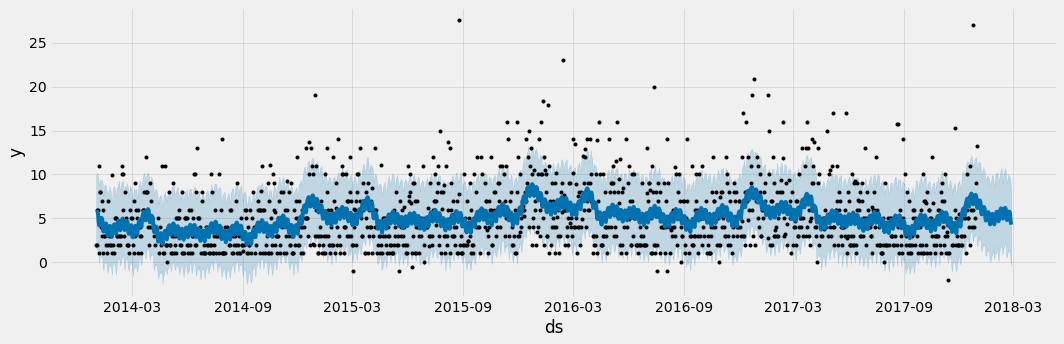

In [20]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

PREDICTING THE UNSEEN DATA

In [21]:
X_tst_forecast = model.predict(X_tst)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
358,2018-12-25,6.541575,2.187039,10.775052
359,2018-12-26,6.867339,2.649510,11.341411
360,2018-12-27,6.948623,2.844923,11.341931
361,2018-12-28,7.023942,2.865718,11.716623
362,2018-12-29,6.855891,2.650393,11.323202
363,2018-12-30,5.989515,1.651626,10.244094
364,2018-12-31,5.568180,1.274444,9.823709


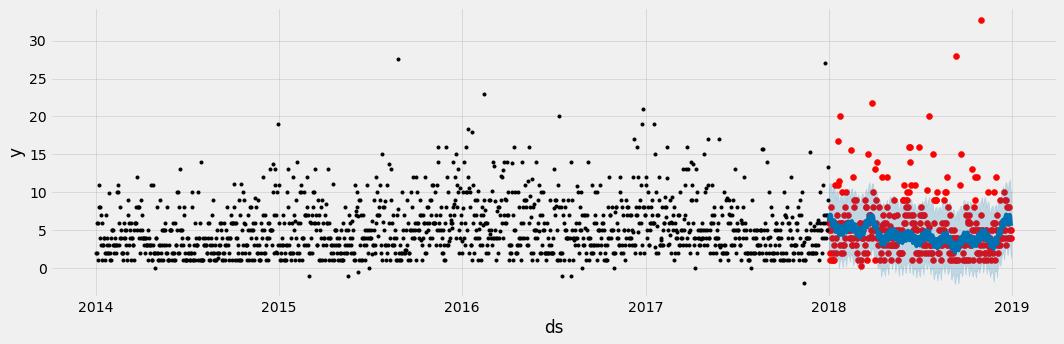

In [22]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(X_tst.ds, X_tst['y'], color='r')
fig = model.plot(X_tst_forecast, ax=ax)

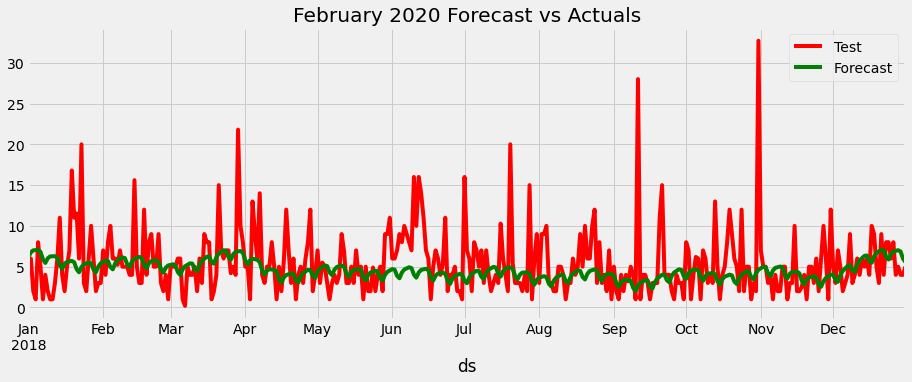

In [23]:
f, ax = plt.subplots(figsize=(14,5))
#f.set_figheight(5)
#f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('February 2020 Forecast vs Actuals')
plt.show()

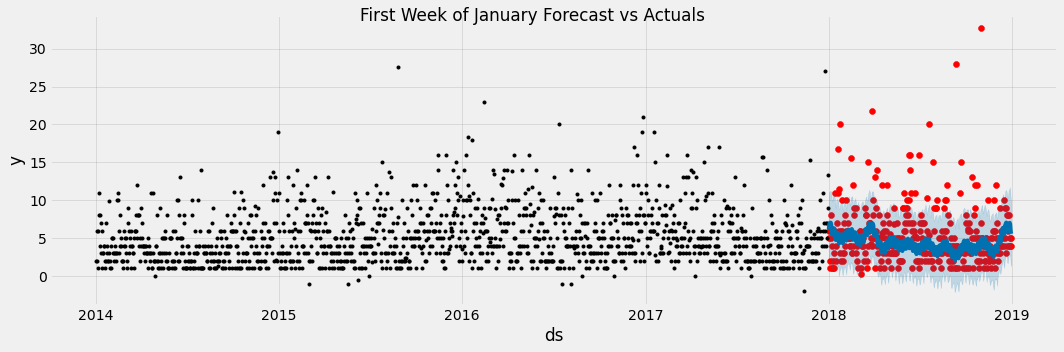

In [24]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(X_tst.ds, X_tst['y'], color='r')
fig = model.plot(X_tst_forecast, ax=ax)
#ax.set_xbound(lower='2018-01-01', upper='2018-01-08')
#ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

In [25]:
mae = mean_absolute_error(X_tst_forecast['yhat'],X_tst['y'])
print("MAE",round(mae,4))

MAE 2.6408


TAKING THE HOLIDAYS INTO ACCOUNT 

In [26]:
import holidays


holiday = pd.DataFrame([])
for date, name in sorted(holidays.AE(years=[2014,2015,2016,2017,2018]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "UAE-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(X_tr)



future = model_with_holidays.make_future_dataframe(periods=57, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1511,2018-02-20,5.416065,0.953456,9.479424
1512,2018-02-21,5.685004,1.477835,9.992806
1513,2018-02-22,5.730433,1.371109,9.957471
1514,2018-02-23,5.769732,1.491273,9.630778
1515,2018-02-24,5.576802,1.362479,9.883092
1516,2018-02-25,4.696350,0.479948,8.886337
1517,2018-02-26,4.278392,-0.050426,8.587673


HYPER TUNING THE MODEL WITH CERTAIN PARAMETER

In [27]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [25,50,75]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [28]:
strt='2018-10-30'
end='2018-12-31'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    #train_model.add_country_holidays(country_name='UAE')
    train_model.fit(X_tr)
    train_forecast = train_model.make_future_dataframe(periods=62, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = df[(df['ds']>strt) & (df['ds']<=end)]
    MAE = mean_absolute_error(Actual['y'],abs(test['yhat']))
    print('Mean Absolute Error(MAE)------------------------------------',MAE)
    model_parameters = model_parameters.append({'MAE':MAE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 25, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.53430067758421
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 25, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.580499691885956
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.5394718777167014
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.5734891873399244
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.5418634051432463
{'cha

Mean Absolute Error(MAE)------------------------------------ 2.545742794967025
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 25, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.531255506405538
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 25, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.5411009925635257
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.53118290552436
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 50, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.5448433935414445
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}
Mean A

Mean Absolute Error(MAE)------------------------------------ 2.5351831348059637
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 25, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.522799480629688
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 25, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.5309409967086927
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.5394948074379124
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 50, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.535986202706667
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}
Mean

Mean Absolute Error(MAE)------------------------------------ 2.5309926772265277
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 25, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.544517006062492
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 25, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.5245405383107653
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.5844754954098357
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 50, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.527574049983467
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}
Mean

SORTING THE VALES BY MAE

In [ ]:
parameters = model_parameters.sort_values(by=['MAE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

TAKING THE MODEL WITH LESS MAE

In [ ]:
parameters['Parameters'][0]

CREATING THE MODEL WITH THE PARAMETR 

In [ ]:
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.3,
                      holidays_prior_scale = 0.4,
                      n_changepoints = 50,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='AE')
final_model.fit(X_tr)

FORECASTING THE MODEL

In [ ]:
future = final_model.make_future_dataframe(periods=122, freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

PLOTING THE VALUES

In [30]:
fig = final_model.plot_components(forecast)

NameError: name 'final_model' is not defined

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast,ax=ax)
plt.show()

In [ ]:
X_tst_final= final_model.predict(X_tst)
X_tst_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

In [ ]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
#plt.title('Jan & Feb 2020 Forecast vs Actuals')
plt.show()

CHECKING THE MEAN ABSOLUTE ERROR

In [ ]:
mae = mean_absolute_error(X_tst_final['yhat'],X_tst['y'])
print("MAE",round(mae,4))

COMPAREING THE SALES AND PREDICTED SALES

In [ ]:
month=X_tst.head(90)
forecast_month=X_tst_final.head(90)
forecast_moth=forecast_month[["ds","yhat"]]
forecast_moth